In [1]:
import tensorflow as tf

# Check if TensorFlow detects a GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

/Users/tobiaslowenthal/Documents/Memoire/Entomo/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
import logging
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, pairwise_distances
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from scipy.spatial.distance import squareform
from tensorflow import keras as tfk
#from tensorflow.keras import Adam
from tensorflow.keras import layers as tfkl

seed = 42
print(tf.__version__)

2.16.2


In [3]:
from PIL import Image

# Path to image folder
image_folder_class_0 = "corrector_museum/class_0"
image_folder_class_1 = "corrector_museum/class_1"

# Load images into a list
images = []
image_shapes = []
labels = []
image_names = []

for i, image_folder in enumerate((image_folder_class_0, image_folder_class_1)):

    image_filenames = os.listdir(image_folder)  # Sorting ensures consistency
    image_filenames.sort(key=lambda f: int(f[1:-4]))
    image_names += image_filenames

    for filename in image_filenames:
        if filename.endswith((".png", ".jpg", ".jpeg", ".JPG")):  # Check for valid image formats
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path)  # Open image
            img_array = np.array(img)  # Convert to numpy array
            images.append(img_array)
            image_shapes.append(img_array.shape)
            labels.append(i)

images = [x.astype("float32") for x in images]
image_shapes = np.asarray(image_shapes, dtype=np.float32)
labels = np.asarray(labels, dtype=np.float32)

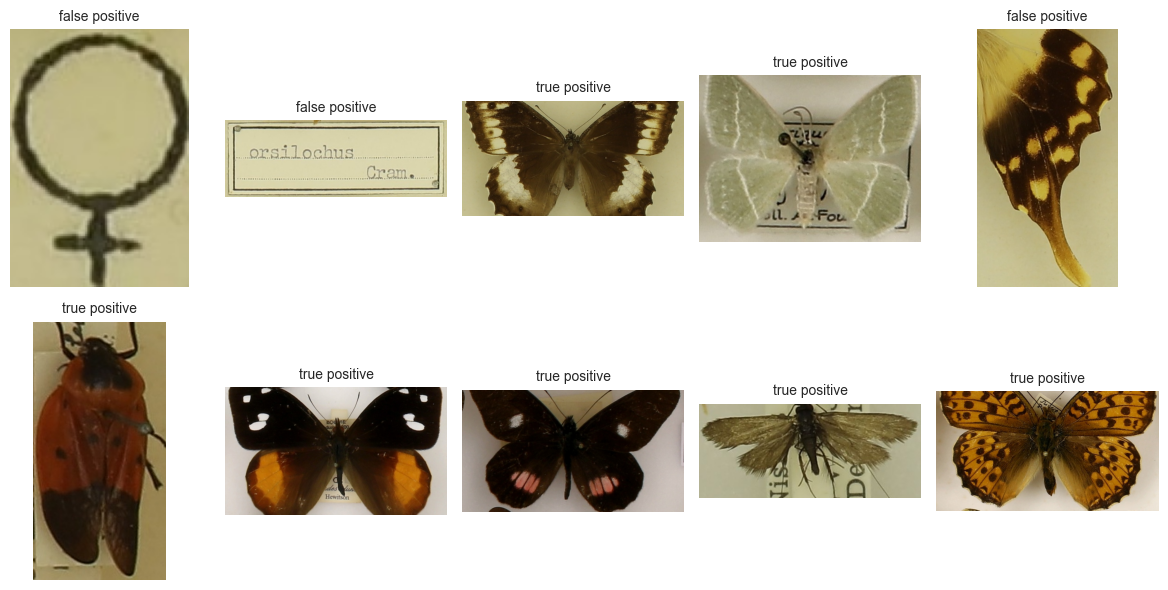

In [4]:
def plot_images(images, titles=None, max_cols=5, figsize=(12, 6)):
    """
    Plots multiple images in a grid layout.

    Args:
    - images (list or array): List of images (H, W, C) in range [0,255] or [0,1].
    - titles (list): Optional list of titles for each image.
    - max_cols (int): Max columns in the grid (default=5).
    - figsize (tuple): Figure size.
    """
    num_images = len(images)
    cols = min(num_images, max_cols)
    rows = (num_images // cols) + (num_images % cols > 0)  # Compute rows dynamically

    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Ensure axes is always a 2D array for easy indexing
    axes = np.array(axes).reshape(rows, cols)

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = images[i].astype(np.uint8)  # Ensure correct dtype
            ax.imshow(img, vmin=0, vmax=255)
            if titles:
                ax.set_title(titles[i], fontsize=10)
        ax.axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

# Plot 10 random images
labels_txt = ["false positive", "true positive"]
random_indices = np.random.choice(np.arange(len(images)), size=10, replace=False)
plot_images([images[x] for x in random_indices], [labels_txt[int(labels[x])] for x in random_indices])

In [5]:
y = labels

# Calculate and print label ratios
ntp = int(np.sum(y))
nfp = int(len(y) - ntp)
fp_ratio = nfp / len(y)
tp_ratio = ntp / len(y)

print(f"true positive ratio: {tp_ratio}")
print(f"false positive ratio: {fp_ratio}")

true positive ratio: 0.7033669206193168
false positive ratio: 0.29663307938068323


In [6]:
#shape analysis
# Extract width and height columns
widths = image_shapes[:, 1]
heights = image_shapes[:, 0]

# Calculate statistics for widths and heights
width_avg = np.mean(widths)
width_min = np.min(widths)
width_max = np.max(widths)
width_std = np.std(widths)

height_avg = np.mean(heights)
height_min = np.min(heights)
height_max = np.max(heights)
height_std = np.std(heights)

# Print results
print("Width statistics:")
print(f"  Average: {width_avg}")
print(f"  Min: {width_min}")
print(f"  Max: {width_max}")
print(f"  Std: {width_std}")

print("\nHeight statistics:")
print(f"  Average: {height_avg}")
print(f"  Min: {height_min}")
print(f"  Max: {height_max}")
print(f"  Std: {height_std}")

Width statistics:
  Average: 345.261474609375
  Min: 33.0
  Max: 2107.0
  Std: 316.3975524902344

Height statistics:
  Average: 280.1695861816406
  Min: 32.0
  Max: 1862.0
  Std: 163.0386962890625


In [7]:
import preprocess
TARGET_SIZE = (int(height_max), int(width_max))
model_name = "pretrained.keras"
redim_images_folder = "corrector_preprocessed_" + model_name[:-6]

if not os.path.exists(redim_images_folder):
    preprocess_func = preprocess.dic[model_name]
    X = preprocess_func(images)
    os.makedirs(redim_images_folder)
    for i, img in enumerate(X):
        img = img.astype(np.uint8)
        img_pil = Image.fromarray(img)
        filename = os.path.join(redim_images_folder, f"i{i}.jpg")
        img_pil.save(filename)
else:
    image_filenames = os.listdir(redim_images_folder)  # Sorting ensures consistency
    image_filenames.sort(key=lambda f: int(f[1:-4]))
    X = []

    for filename in image_filenames:
        if filename.endswith((".png", ".jpg", ".jpeg", ".JPG")):  # Check for valid image formats
            img_path = os.path.join(redim_images_folder, filename)
            img = Image.open(img_path)  # Open image
            img_array = np.array(img)  # Convert to numpy array
            X.append(img_array)
    X = np.asarray(X, dtype=np.float32) # Now that cropped images have identical dims, we can convert them to array

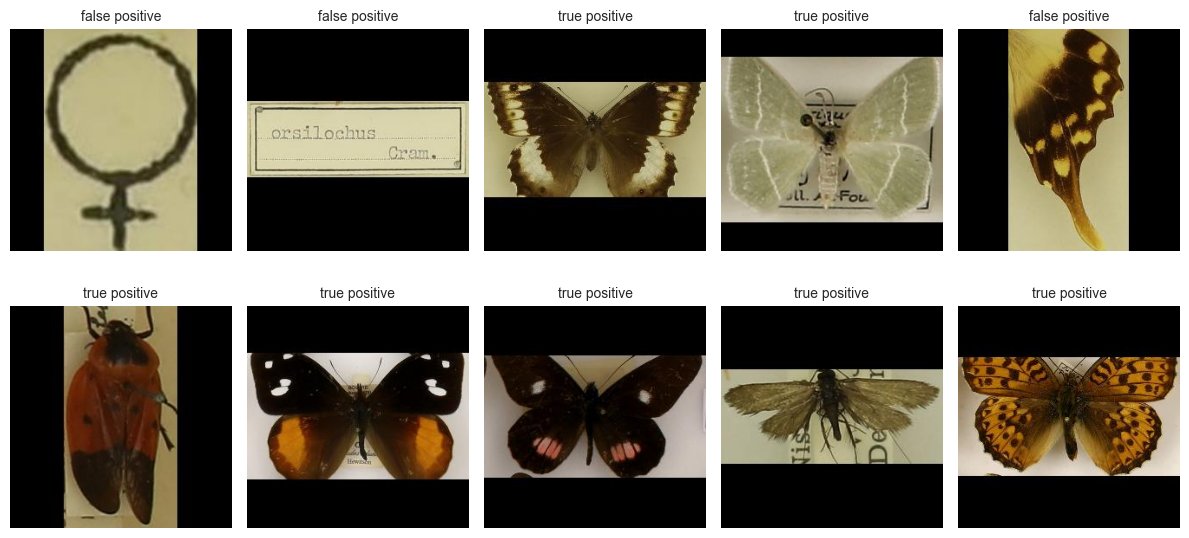

In [8]:
# Plot 10 random preprocessed images
plot_images(X[random_indices], [labels_txt[int(labels[x])] for x in random_indices])

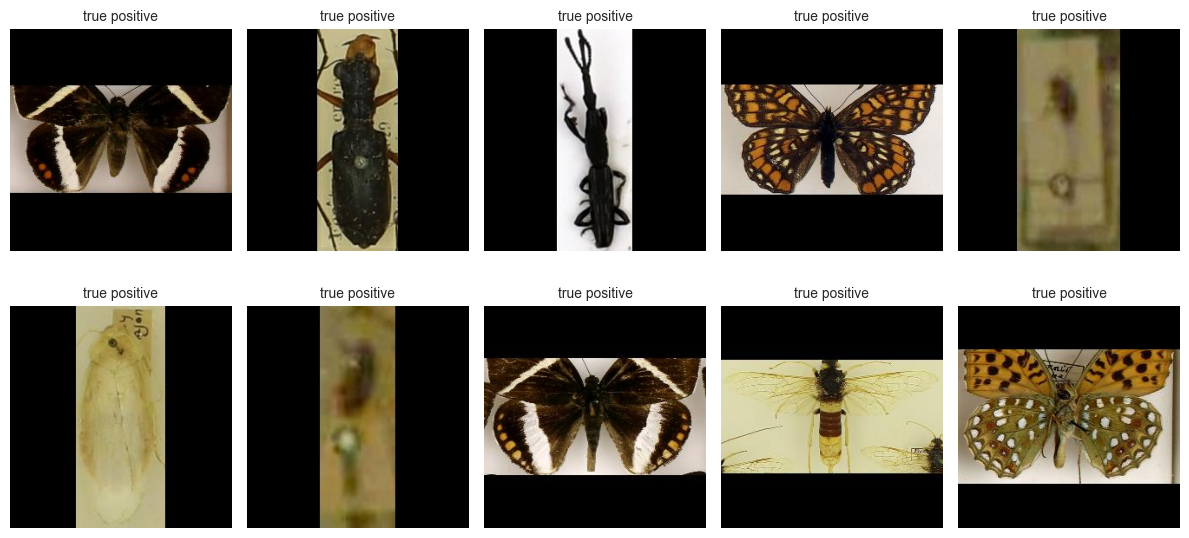

In [9]:
# Plot 10 images of the balanced dataset
random_indices = np.random.choice(np.arange(len(X)), size=10, replace=False)
plot_images(X[random_indices], [labels_txt[int(y[x])] for x in random_indices])

In [10]:
# Convert to one-hot encoding
y = tfk.utils.to_categorical(y, num_classes=2)
indices = np.arange(len(y))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test, idx_train_val, idx_test  = train_test_split(X, y, indices, test_size=0.2, stratify=np.argmax(y,axis=1), random_state=seed)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(X_train_val, y_train_val, idx_train_val, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1), random_state=seed)

# Print shapes of the datasets
print(f"X_train length: {len(X_train)}, y_train shape: {y_train.shape}")
print(f"X_val length: {len(X_val)}, y_val shape: {y_val.shape}")
print(f"X_test length: {len(X_test)}, y_test shape: {y_test.shape}")
print()

# Calculate and print label ratios
train_label_ratios = np.sum(y_train, axis=0) / len(y_train)
val_label_ratios = np.sum(y_val, axis=0) / len(y_val)
test_label_ratios = np.sum(y_test, axis=0) / len(y_test)

print(f"Train Label Ratios (0: fp, 1: tp): {train_label_ratios}")
print(f"Validation Label Ratios (0: fp, 1: tp): {val_label_ratios}")
print(f"Test Label Ratios (0: fp, 1: tp): {test_label_ratios}")

X_train length: 2441, y_train shape: (2441, 2)
X_val length: 814, y_val shape: (814, 2)
X_test length: 814, y_test shape: (814, 2)

Train Label Ratios (0: fp, 1: tp): [0.29659975 0.70340025]
Validation Label Ratios (0: fp, 1: tp): [0.2972973 0.7027027]
Test Label Ratios (0: fp, 1: tp): [0.2960688 0.7039312]


In [11]:
def build_convnet(input_shape=(256,256,3)):
    convnet = tfk.applications.EfficientNetB0(
        input_shape=(256, 256, 3),
        include_top=False,
        weights="imagenet"
    )

    # Use the supernet as feature extractor, i.e. freeze all its weigths
    convnet.trainable = False

    # Create an input layer with shape (224, 224, 3)
    inputs = tfk.Input(shape=input_shape)

    # Connect ConvNeXt to the input
    x = convnet(inputs, training = False)
    #dropout = tfkl.Dropout(0.1)(x)  # Regularize with dropout

    x = tfkl.GlobalAveragePooling2D()(x)  # Reduce dimensionality
    x = tfkl.BatchNormalization()(x)

    dense1 = tfkl.Dense(units=256, activation='gelu',name='dense1')(x)
    dense1_dropout = tfkl.Dropout(0.2, name = 'dense1_dropout')(dense1)  # Regularize with dropout

    dense2 = tfkl.Dense(units=128, activation='gelu',name='dense2')(dense1_dropout)
    dense2_dropout = tfkl.Dropout(0.2, name = 'dense2_dropout')(dense2)  # Regularize with dropout

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(2, activation='softmax', name = 'output')(dense2_dropout)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='conv_model')

    # Compile the model with Binary Cross-Entropy loss and AdamW optimizer
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer="adam", metrics=['accuracy'])

    return model

model = build_convnet()
# Display model summary
model.summary()

2025-04-07 08:44:27.811498: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-07 08:44:27.812269: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-07 08:44:27.812275: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-07 08:44:27.812349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-07 08:44:27.812750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "conv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1_dropout (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2_dropout (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,415,781 (16.84 MB)

 Trainable params: 363,650 (1.39 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [12]:
# Train the model
#y_train = tfk.utils.to_categorical(y_train, num_classes=2)
LOADED_MODEL = False
class_weight_dict = {0: 0.83,
                     1: 0.17}
if os.path.exists(model_name):
    LOADED_MODEL = True
    model = tfk.models.load_model(model_name)
else:
    conv_history = model.fit(
        x = X_train, # We need to apply the preprocessing thought for the ConvNeXt network, which is nothing
        y = y_train,
        #class_weight=class_weight_dict,
        batch_size = 32,
        epochs = 100,
        validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the ConvNeXt network
        callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
    ).history

In [13]:
if not LOADED_MODEL:
    # Plot the transfer learning and the fine-tuned ConvNeXt training histories
    plt.figure(figsize=(15,5))
    plt.plot(conv_history['loss'], label='training', alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(conv_history['val_loss'], label='validation', alpha=.8, color='#ff7f0e')

    plt.legend(loc='upper left')
    plt.title('Binary Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15,5))
    plt.plot(conv_history['accuracy'], label='training', alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(conv_history['val_accuracy'], label='validation', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()
else:
    print("This is a loaded model")

This is a loaded model


In [14]:
# Save the best model
if not LOADED_MODEL:
    model.save(model_name)

In [15]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)
print(predictions)

2025-04-07 08:44:42.631551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Predictions Shape: (814, 2)
[[5.8945996e-01 4.1054004e-01]
 [2.1638074e-08 1.0000000e+00]
 [1.8653792e-34 1.0000000e+00]
 ...
 [5.8818829e-01 4.1181171e-01]
 [5.8082069e-33 1.0000000e+00]
 [1.3303495e-16 1.0000000e+00]]


In [16]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1:', round(f1, 4))

Accuracy: 0.9312
Precision: 0.9229
Recall: 0.9103
F1: 0.9162


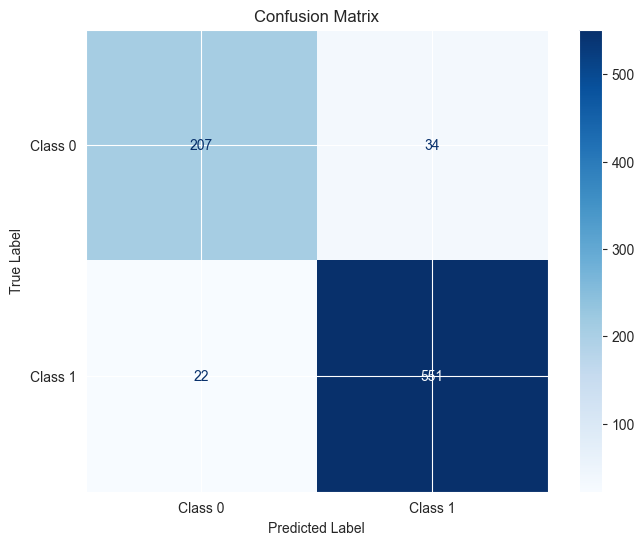

In [17]:
# Create a ConfusionMatrixDisplay object for better visualization
disp = ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1'])

# Plot the confusion matrix with a heatmap and other styling options
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='.4g')

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add color bar
#plt.colorbar()

# Show the plot
plt.show()

56 errors in test set


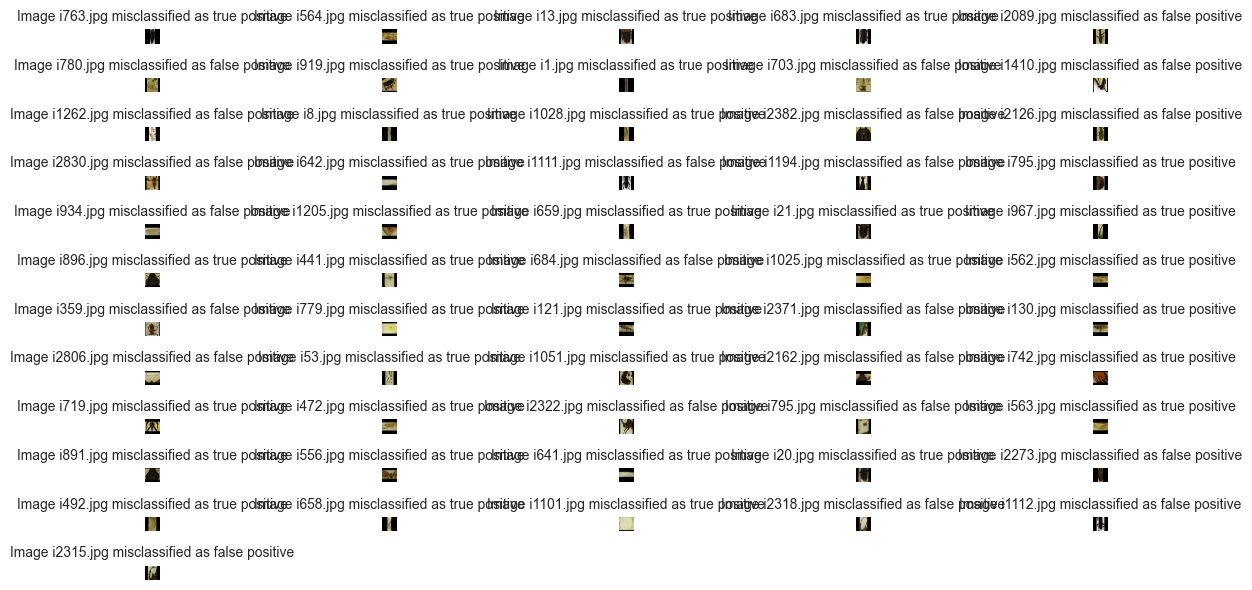

In [18]:
divergences = (~np.equal(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))).astype(int)
error_indices = np.flatnonzero(divergences)
nerrors = len(error_indices)
print(f"{nerrors} errors in test set")
titles = []
for error_index in error_indices:
    s = "Image "
    s += image_names[idx_test[error_index]]
    s += " misclassified as "
    s += labels_txt[np.argmax(predictions, axis=-1)[error_index]]
    titles.append(s)
plot_images(X_test[error_indices], titles)

Examples of correct classification


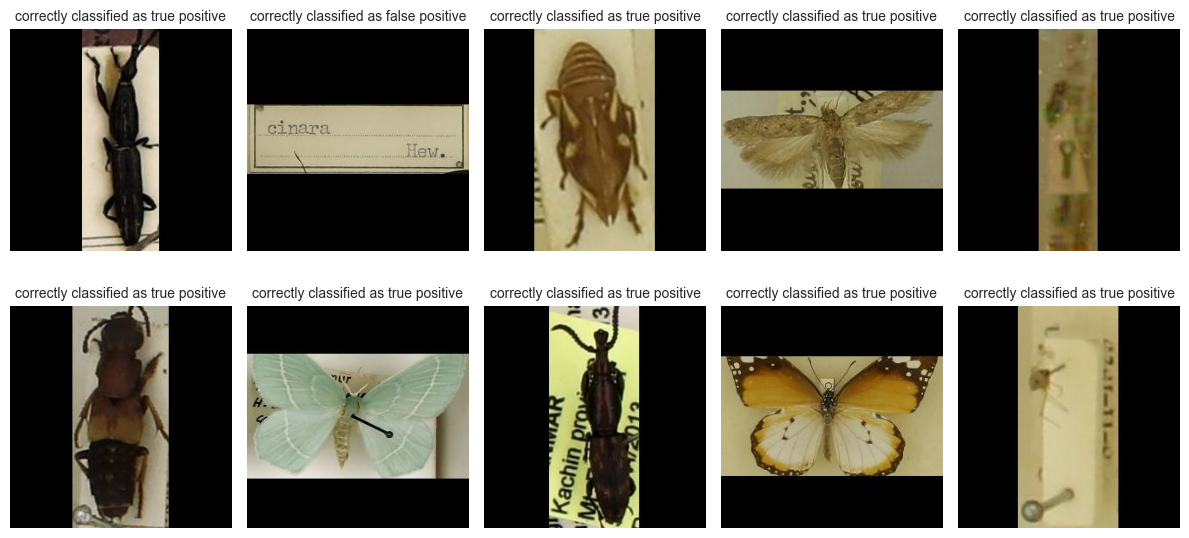

In [19]:
print("Examples of correct classification")
random_indices = np.random.choice(np.arange(len(X_test)), size=10, replace=False)
while np.intersect1d(random_indices, error_indices).size > 0:
    random_indices = np.random.choice(np.arange(len(X_test)), size=10, replace=False)
plot_images(X_test[random_indices], ["correctly classified as " + labels_txt[x] for x in np.argmax(y_test, axis=-1)[random_indices]])

In [20]:
#switch to fcnn
def build_fcnn():
    convnet = tfk.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet"
    )
    convnet.trainable = False

    inputs = tfk.Input(shape=(None, None, 3))
    x = convnet(inputs, training=False)

    #x = tfkl.AveragePooling2D(pool_size=8)(x)

    x = tfkl.Conv2D(filters=256, kernel_size=1, activation='gelu', name='conv1')(x)
    x = tfkl.Dropout(0.2, name='conv1_dropout')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=1, activation='gelu', name='conv2')(x)
    x = tfkl.Dropout(0.2, name='conv2_dropout')(x)

    outputs = tfkl.Conv2D(filters=2, kernel_size=1, activation='softmax', name='output_conv')(x)

    model = tfk.Model(inputs=inputs, outputs=outputs, name='fcnn_model')
    return model

fcnn = build_fcnn()
# Display model summary
fcnn.summary()

Model: "fcnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None,     │       327,936 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_dropout (Dropout)         │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, None, None,     │        32,896 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_dropout (Dropout)         │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_conv (Conv2D)            │ (None, None, None, 2)  │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,410,661 (16.83 MB)

 Trainable params: 361,090 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
for layer_fcnn, layer_orig in zip(fcnn.layers[1].layers, model.layers[1].layers):
    layer_fcnn.set_weights(layer_orig.get_weights())

def transfer_dense_to_conv(dense_layer, conv_layer):
    dense_weights, dense_bias = dense_layer.get_weights()
    conv_weights = np.expand_dims(np.expand_dims(dense_weights, axis=0), axis=0)  # Reshape for Conv2D
    conv_layer.set_weights([conv_weights, dense_bias])

transfer_dense_to_conv(model.get_layer("dense1"), fcnn.get_layer("conv1"))
transfer_dense_to_conv(model.get_layer("dense2"), fcnn.get_layer("conv2"))
transfer_dense_to_conv(model.get_layer("output"), fcnn.get_layer("output_conv"))

In [22]:
import cv2

cnn_full_img_res = 2016
yolo_res = 640

def visualize_heatmap(img_array, img_shape, heatmap, alpha=0.1, show_heatmap=False, output_path=None, name=None):

    heatmap  = tf.image.resize(heatmap, (img_array.shape[0], img_array.shape[1]), method=tf.image.ResizeMethod.BILINEAR)
    heatmap = np.uint8(heatmap * 255)  # Scale to [0,255]
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map
    heatmap_RGB = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img_to_plot = cv2.addWeighted(np.uint8(img_array), 1 - alpha, heatmap_RGB, alpha, 0)  # Blend images
    superimposed_img = cv2.cvtColor(superimposed_img_to_plot, cv2.COLOR_BGR2RGB)

    if show_heatmap:
        plt.figure(figsize=(8, 8))
        plt.imshow(superimposed_img_to_plot)
        plt.axis("off")
        plt.show()

    if output_path is not None:
        superimposed_img = tf.image.resize(superimposed_img, img_shape, method=tf.image.ResizeMethod.BILINEAR)
        #print(type(superimposed_img))
        cv2.imwrite(os.path.join(output_path, name), superimposed_img.numpy())

root_folder = "InsectoVision_Sample_2"
cam_folder = os.path.join(root_folder, "Sample_CAM")
img_folder = os.path.join(root_folder, "Sample")
if not os.path.exists(cam_folder):
    os.makedirs(cam_folder)

SAVE_CAMS = True
slice_size = 1 if not SAVE_CAMS else len(os.listdir(img_folder))

for i, f in enumerate(os.listdir(img_folder)[:slice_size]):
    image_path = os.path.join(img_folder, f)  # Replace with your image
    img = Image.open(image_path)  # Open image
    img_array = np.array(img, dtype=np.float32)  # Convert to numpy array
    img_shape = img_array.shape[:-1]
    factor = np.max(img_array.shape)/cnn_full_img_res if np.max(img_array.shape) > cnn_full_img_res else 1
    img_array  = tf.image.resize(img_array, (int(img_array.shape[0]/factor), int(img_array.shape[1]/factor)), method=tf.image.ResizeMethod.BILINEAR)

    preds = fcnn.predict(np.expand_dims(img_array, axis=0))
    preds = np.squeeze(preds)

    print("Storing", f)
    visualize_heatmap(img_array, img_shape, np.expand_dims(preds[:, :, 1], axis=-1), show_heatmap=(not SAVE_CAMS), output_path=(cam_folder if SAVE_CAMS else None), name=f)
    print("Done")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Storing Mixed[]BE-RBINS-ENT Collection-prince-leopold-of-belgium-expedition-1929[]drawers[]box_20[]box-020.jpg


[ WARN:0@115.136] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


Done
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Storing Classified[]be-rbins-ent-collection-arsene-fouassin[]be_rbins_ent_drawers[]be_rbins_ent_box-n043[]be_rbins_ent_box-n403.jpg
Done
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Storing Classified[]be-rbins-ent-belgian-microlepidoptera[]depressariidae[]box-10[]a3.jpg
Done
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Storing Classified[]be-rbins-ent-belgian-microlepidoptera[]yponomeutidae[]box-01[]b1.jpg
Done
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Storing Classified[]be-rbins-ent-pieridae-south-america[]be-rbins-ent-drawers[]be_rbins_ent_box-73-leptophobia-eleone-eleone[]be_rbins_ent_box-73-leptophobia-eleone-eleone.jpg
Done
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Storing Classified[]be-rbins-ent-belgian-microlepidoptera[]coleophoridae[]box-09[]b4.jpg
Done
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Storing Classified[]be-rbins-ent-belgian-microlepidoptera[]tortricidae[]box-06[]a2.jpg
Done
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Storing Mixed[]be-rbins-ent-collection-queen-elisa

KeyboardInterrupt: 

In [24]:
if not os.path.exists("fcnn.keras"):
    fcnn.save("fcnn.keras")

In [ ]:
def build_efficient_net():
    convnet = tfk.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet"
    )

    inputs = tfk.Input(shape=(None, None, 3))
    x = convnet(inputs, training=False)

    x = tfkl.Conv2D(1000, kernel_size=1, activation=None)(x)
    #x = tfkl.MaxPooling2D(pool_size=7)(x)
    x = tfkl.Softmax()(x)

    model = tfk.Model(inputs=inputs, outputs=x, name='efficient_net_model')
    return model

efficient_net = build_efficient_net()
# Display model summary
efficient_net.summary()

In [ ]:
SAVE_CAMS = False
slice_size = 1 if not SAVE_CAMS else len(os.listdir(img_folder))

insect_classes = [300, 305, 307, 308, 309, 311, 314, 315, 316, 317, 319, 323, 324, 325, 326]

for i, f in enumerate(os.listdir(img_folder)[:slice_size]):
    image_path = os.path.join(img_folder, f)  # Replace with your image
    img = Image.open(image_path)  # Open image
    img_array = np.array(img, dtype=np.float32)  # Convert to numpy array
    img_shape = img_array.shape[:-1]

    preds = efficient_net.predict(np.expand_dims(img_array, axis=0))
    preds = np.squeeze(preds)

    # Select only the relevant class indices (shape: 127, 86, len(insect_classes))
    insect_pred = preds[..., insect_classes]

    # Aggregate by taking max along the last axis (shape: 127, 86, 1)
    aggregated_pred = np.max(insect_pred, axis=-1, keepdims=True)
    # Normalize heatmap with a lower threshold for better visibility
    aggregated_pred = np.clip(aggregated_pred, 0, 0.25) / 0.25  # Adjust threshold (0.5 makes weaker activations visible)

    print("Storing", f)
    visualize_heatmap(img_array, img_shape, aggregated_pred, alpha=0.5, show_heatmap=(not SAVE_CAMS), output_path=(cam_folder if SAVE_CAMS else None), name=f)
    print("Done")